In [176]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit




import os
import numpy as np
from matplotlib import pyplot as plt
import csv


import json
import glob

import matplotlib.image as mpimg
from PIL import Image
from pathlib import Path

import random
from sklearn.model_selection import StratifiedShuffleSplit


import torchvision.models as models

In [41]:
sample_batched['image'].shape

torch.Size([16, 860, 1296, 3])

In [43]:
860*1296*3

3343680

In [214]:
def train(args, model, device, train_loader, optimizer, epoch):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    train_loss= 0
    train_accuracy = 0

    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image']
        target = sample_batched['label']
        data, target = data.to(device, dtype= torch.float), target.to(device, dtype= torch.long)
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = F.nll_loss(output, target)   # Compute loss
        train_loss += loss
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        ## added for assignment
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct = pred.eq(target.view_as(pred)).sum().item()
        train_accuracy += correct # accuracy per batch
        
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                epoch, batch_idx * len(data), len(train_loader.sampler),
                100. * batch_idx * len(data) / len(train_loader.sampler), loss.item(),
                correct, len(output),
                100. * correct / len(output)))
    train_loss /= len(train_loader.sampler)
    train_accuracy /= len(train_loader.sampler)
    return train_accuracy,train_loss

def test(model, device, test_loader):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for batch_idx, sample_batched in enumerate(test_loader):
            data = sample_batched['image']
            target = sample_batched['label']
            data, target = data.to(device, dtype= torch.float), target.to(device, dtype= torch.long)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.sampler)
    
    accuracy = correct / len(test_loader.sampler)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.sampler),
        100. * correct / len(test_loader.sampler)))
    return accuracy,test_loss

class oversample(torch.utils.data.Dataset):
    def __init__(self, filenames, targets, directory, transform=None):
        self.filenames = filenames
        self.targets = targets
        self.dir = directory
        self.transform=transform
    def __len__(self):
        return len(self.filenames)
    def __getitem__(self,idx):
        img_name = self.dir+ self.filenames[idx]
        image = np.array(Image.open(img_name))
        label = self.targets[idx]
        sample = {'image': image, 'label':label}
        if self.transform:
            sample = self.transform(sample)
        return sample


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'label': label}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': label}
    
class Normalize(object):
    
    """convert tensor image of size (c,h,w) to normalized"""
    # should write before totensor
    def __init__(self, mean,std):
        self.mean = np.array(mean)
        self.std = np.array(std)
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = image/255.
        image = (image-self.mean)/self.std
        image_max = np.max(image)
        image_min = np.min(image)
#         image = (image - image_min)/(image_max-image_min)
        
        return {'image': image,
                'label': label}



In [215]:

# # Training settings
# # Use the command line to modify the default settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--step', type=int, default=1, metavar='N',
                    help='number of epochs between learning rate reductions (default: 1)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')

parser.add_argument('--evaluate', action='store_true', default=False,
                    help='evaluate your model on the official test set')
parser.add_argument('--load-model', type=str,
                    help='model file path')

parser.add_argument('--save-model', action='store_true', default=True,
                    help='For Saving the current Model')
args = parser.parse_args([])

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

# kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# # Evaluate on the official test set
# if args.evaluate:
#     assert os.path.exists(args.load_model)

#     # Set the test model
#     model = Net().to(device)
#     model.load_state_dict(torch.load(args.load_model))

#     test_dataset = datasets.MNIST('../data', train=False,
#                 transform=transforms.Compose([
#                     transforms.ToTensor(),
#                     transforms.Normalize((0.1307,), (0.3081,))
#                 ]))

#     test_loader = torch.utils.data.DataLoader(
#         test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)

#     test_accuracy,test_loss = test(model, device, test_loader)
#     import csv
#     exp_name = 'best_Net_test_full'
#     with open('./figures/'+exp_name+'.csv', 'w', newline='') as csvfile:
#         spamwriter = csv.writer(csvfile, delimiter=' ',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
#         spamwriter.writerow(['TEST_ACCURACY','TEST_LOSS'])
#         spamwriter.writerow([test_accuracy,test_loss])


In [205]:
# load data
with open('/net/fluo/data2/groupMembers/rccheng/PhenoCam/Annotations/annotations-balanced.json', 'r') as openfile: 
  
    # Reading from json file 
    json_object2 = json.load(openfile) 
files = np.array(list(json_object2.keys()))
target = np.array([json_object2[i] for i in files])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state = 42)
# sss.get_n_splits(files,target)
for rest_idx, test_idx in sss.split(files,target):
    files_rest = files[rest_idx]
    files_test = files[test_idx]
    
    target_rest = target[rest_idx]
    target_test = target[test_idx]

for train_idx, validate_idx in sss.split(files_rest,target_rest):
    files_train = files_rest[train_idx]
    files_validate = files_rest[validate_idx]
    
    target_train = target_rest[train_idx]
    target_validate = target_rest[validate_idx]
imag_mean = np.array([ 93.18228285, 104.2707721,   79.90378895])
    


TrainSet = oversample(filenames = files_train, targets = target_train, directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/',transform= transforms.Compose([ToTensor()]))
means = []
stds = []
for i in TrainSet:
    img = i['image']
    img = img/255.
    means.append(torch.mean(img.type(torch.float),dim=(1,2)))
    stds.append(torch.std(img.type(torch.float),dim=(1,2)))
mean = torch.mean(torch.stack(means),dim=0)
std = torch.mean(torch.stack(stds),dim=0)





KeyboardInterrupt: 

In [216]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
TrainSet = oversample(filenames = files_train, targets = target_train, directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/',transform= transforms.Compose([Normalize(mean,std),ToTensor()]))
TrainLoader = torch.utils.data.DataLoader(TrainSet,batch_size=16,shuffle=True)
    
ValidateSet = oversample(filenames = files_validate, targets = target_validate, directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/' ,transform= transforms.Compose([ToTensor()]))
ValidateLoader = torch.utils.data.DataLoader(ValidateSet,batch_size=1,shuffle=True)

TestSet = oversample(filenames = files_test, targets = target_test, directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/',transform= transforms.Compose([ ToTensor()]))
TestLoader = torch.utils.data.DataLoader(TestSet,batch_size=1,shuffle=True)




In [209]:
class Net(nn.Module):
    '''
    Build the best MNIST classifier.
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3), stride=1)
     
        self.dropout1 = nn.Dropout2d(.1)
        self.fc0 = nn.Linear(8*429*647,64)
#         self.fc0 = nn.Linear(3343680, 64)
        self.fc1 = nn.Linear(64,6)
    

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, 2)
        x = self.dropout1(x)
        xshape = x.shape
        x = torch.flatten(x, 1)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
     
        output = F.log_softmax(x, dim=1)
        return output




In [210]:
device='cpu'
args.lr = 1
args.epochs = 7
model = Net().to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)


Train Epoch: 1 [0/556 (0%)]	Loss: 1.809644, Accuracy: 3/16 (19%)



KeyboardInterrupt: 

In [217]:
device='cpu'
args.lr = 1
args.epochs = 7
model = models.resnet18(pretrained=True).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)



Train Epoch: 1 [0/556 (0%)]	Loss: 0.658868, Accuracy: 0/16 (0%)

Train Epoch: 1 [160/556 (29%)]	Loss: -20.085651, Accuracy: 7/16 (44%)

Train Epoch: 1 [320/556 (58%)]	Loss: -44.803833, Accuracy: 4/16 (25%)

Train Epoch: 1 [480/556 (86%)]	Loss: -88.304359, Accuracy: 12/16 (75%)


Test set: Average loss: -95.9232, Accuracy: 45/139 (32%)

Train Epoch: 2 [0/556 (0%)]	Loss: -84.898941, Accuracy: 7/16 (44%)

Train Epoch: 2 [160/556 (29%)]	Loss: -138.297165, Accuracy: 8/16 (50%)

Train Epoch: 2 [320/556 (58%)]	Loss: -203.603012, Accuracy: 11/16 (69%)

Train Epoch: 2 [480/556 (86%)]	Loss: -284.309235, Accuracy: 11/16 (69%)


Test set: Average loss: -601.4115, Accuracy: 48/139 (35%)

Train Epoch: 3 [0/556 (0%)]	Loss: -287.417786, Accuracy: 7/16 (44%)

Train Epoch: 3 [160/556 (29%)]	Loss: -376.472290, Accuracy: 12/16 (75%)

Train Epoch: 3 [320/556 (58%)]	Loss: -409.944427, Accuracy: 8/16 (50%)

Train Epoch: 3 [480/556 (86%)]	Loss: -549.533630, Accuracy: 7/16 (44%)


Test set: Average loss: -1073

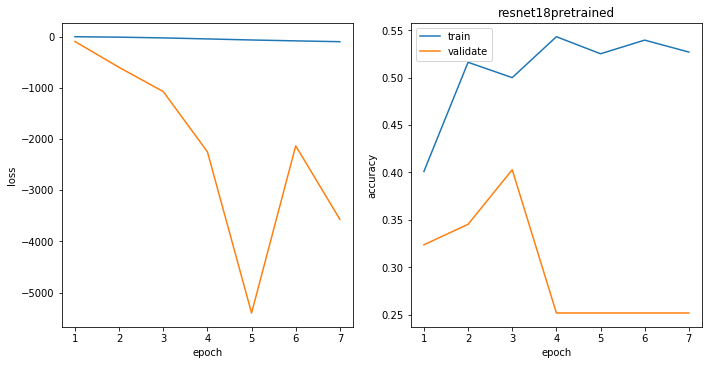

In [220]:
net_name = 'resnet18pretrained'
torch.save(model.state_dict(), net_name+'.pt')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs+1),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs+1),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs+1),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs+1),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.legend()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

In [223]:
TrainSet = oversample(filenames = files_train, targets = target_train, directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/',transform= transforms.Compose([ToTensor()]))
means = []
stds = []
for i in TrainSet:
    img = i['image']
    img = img/255.
    means.append(torch.mean(img.type(torch.float),dim=(1,2)))
    stds.append(torch.std(img.type(torch.float),dim=(1,2)))
own_mean = torch.mean(torch.stack(means),dim=0)
own_std = torch.mean(torch.stack(stds),dim=0)






TrainSet = oversample(filenames = files_train, targets = target_train, directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/',transform= transforms.Compose([Normalize(own_mean,own_std),ToTensor()]))

TrainLoader = torch.utils.data.DataLoader(TrainSet,batch_size=16,shuffle=True)
    
ValidateSet = oversample(filenames = files_validate, targets = target_validate, directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/' ,transform= transforms.Compose([ToTensor()]))
ValidateLoader = torch.utils.data.DataLoader(ValidateSet,batch_size=1,shuffle=True)

TestSet = oversample(filenames = files_test, targets = target_test, directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/',transform= transforms.Compose([ ToTensor()]))
TestLoader = torch.utils.data.DataLoader(TestSet,batch_size=1,shuffle=True)






Train Epoch: 1 [0/556 (0%)]	Loss: -0.306623, Accuracy: 0/16 (0%)

Train Epoch: 1 [160/556 (29%)]	Loss: -28.415154, Accuracy: 9/16 (56%)

Train Epoch: 1 [320/556 (58%)]	Loss: -73.197502, Accuracy: 6/16 (38%)

Train Epoch: 1 [480/556 (86%)]	Loss: -142.187866, Accuracy: 7/16 (44%)


Test set: Average loss: -565.2825, Accuracy: 56/139 (40%)

Train Epoch: 2 [0/556 (0%)]	Loss: -201.243805, Accuracy: 8/16 (50%)

Train Epoch: 2 [160/556 (29%)]	Loss: -272.890106, Accuracy: 7/16 (44%)

Train Epoch: 2 [320/556 (58%)]	Loss: -381.305328, Accuracy: 5/16 (31%)

Train Epoch: 2 [480/556 (86%)]	Loss: -650.311401, Accuracy: 8/16 (50%)


Test set: Average loss: -3021.8739, Accuracy: 51/139 (37%)

Train Epoch: 3 [0/556 (0%)]	Loss: -669.739380, Accuracy: 4/16 (25%)

Train Epoch: 3 [160/556 (29%)]	Loss: -909.791016, Accuracy: 6/16 (38%)

Train Epoch: 3 [320/556 (58%)]	Loss: -1175.708740, Accuracy: 7/16 (44%)

Train Epoch: 3 [480/556 (86%)]	Loss: -1455.398804, Accuracy: 6/16 (38%)


Test set: Average loss: -7

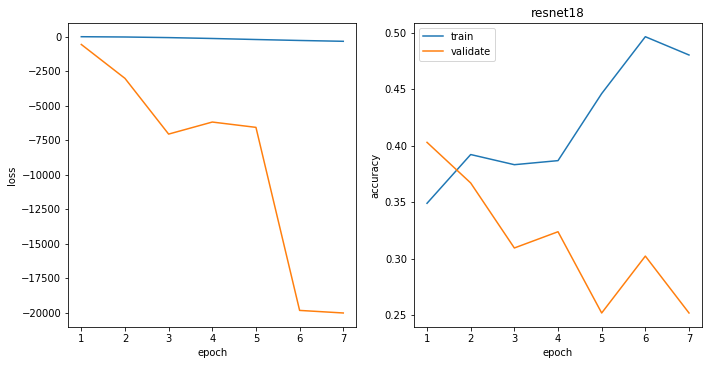

In [224]:
device='cpu'
args.lr = 1
args.epochs = 7
model = models.resnet18(pretrained=False).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)

net_name = 'resnet18'
torch.save(model.state_dict(), net_name+'.pt')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs+1),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs+1),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs+1),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs+1),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.legend()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

In [225]:
device='cpu'
args.lr = 1
args.epochs = 7
model = models.alexnet(pretrained=True).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)

net_name = 'alexnetpretrained'
torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/rccheng/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Train Epoch: 1 [0/556 (0%)]	Loss: -0.141752, Accuracy: 0/16 (0%)

Train Epoch: 1 [160/556 (29%)]	Loss: -408624631650451456.000000, Accuracy: 4/16 (25%)

Train Epoch: 1 [320/556 (58%)]	Loss: -125042656656189797554978816.000000, Accuracy: 1/16 (6%)

Train Epoch: 1 [480/556 (86%)]	Loss: -490578725534799844989730816.000000, Accuracy: 2/16 (12%)


Test set: Average loss: -109885951623890370571525947392.0000, Accuracy: 35/139 (25%)

Train Epoch: 2 [0/556 (0%)]	Loss: -587842909905736345214517248.000000, Accuracy: 5/16 (31%)

Train Epoch: 2 [160/556 (29%)]	Loss: -601789275614759272360968192.000000, Accuracy: 5/16 (31%)

Train Epoch: 2 [320/556 (58%)]	Loss: -766331834675518890533978112.000000, Accuracy: 7/16 (44%)

Train Epoch: 2 [480/556 (86%)]	Loss: -865978563617527569026383872.000000, Accuracy: 6/16 (38%)


Test set: Average loss: -161596500642308473994401021952.0000, Accuracy: 35/139 (25%)

Train Epoch: 3 [0/556 (0%)]	Loss: -889838984355013105012441088.000000, Accuracy: 3/16 (19%)



KeyboardInterrupt: 

Train Epoch: 1 [0/556 (0%)]	Loss: -0.001279, Accuracy: 0/16 (0%)

Train Epoch: 1 [160/556 (29%)]	Loss: -759532805582487552.000000, Accuracy: 5/16 (31%)

Train Epoch: 1 [320/556 (58%)]	Loss: -196217278842285552157327360.000000, Accuracy: 6/16 (38%)

Train Epoch: 1 [480/556 (86%)]	Loss: -2298261840121257095315062784.000000, Accuracy: 3/16 (19%)


Test set: Average loss: -599456140739524099141342855168.0000, Accuracy: 32/139 (23%)

Train Epoch: 2 [0/556 (0%)]	Loss: -3594799068761420183495507968.000000, Accuracy: 3/16 (19%)

Train Epoch: 2 [160/556 (29%)]	Loss: -3870869793941600360099479552.000000, Accuracy: 3/16 (19%)

Train Epoch: 2 [320/556 (58%)]	Loss: -4282157514365312984871337984.000000, Accuracy: 3/16 (19%)

Train Epoch: 2 [480/556 (86%)]	Loss: -4661230136086604428053839872.000000, Accuracy: 4/16 (25%)


Test set: Average loss: -903665128667521268421052334080.0000, Accuracy: 32/139 (23%)

Train Epoch: 3 [0/556 (0%)]	Loss: -5999771338852367113645981696.000000, Accuracy: 6/16 (38%)

T

ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

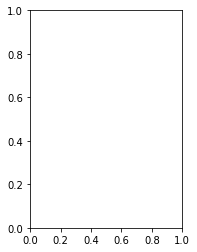

In [226]:
device='cpu'
args.lr = 1
args.epochs = 7
model = models.alexnet(pretrained=False).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)

net_name = 'alexnet'


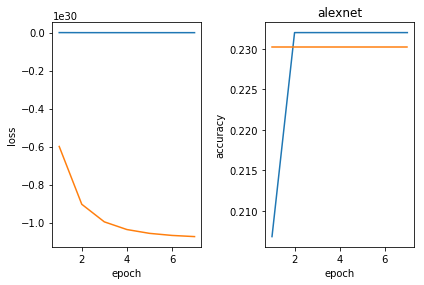

In [227]:
torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs+1),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs+1),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs+1),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs+1),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

Train Epoch: 1 [0/556 (0%)]	Loss: -0.005280, Accuracy: 0/16 (0%)

Train Epoch: 1 [160/556 (29%)]	Loss: -841348702755880960.000000, Accuracy: 1/16 (6%)

Train Epoch: 1 [320/556 (58%)]	Loss: -187690640329094786113863680.000000, Accuracy: 4/16 (25%)

Train Epoch: 1 [480/556 (86%)]	Loss: -2262728688668809629257433088.000000, Accuracy: 2/16 (12%)


Test set: Average loss: -563113517729495271677456547840.0000, Accuracy: 32/139 (23%)

Train Epoch: 2 [0/556 (0%)]	Loss: -3131519273952933482332160000.000000, Accuracy: 1/16 (6%)

Train Epoch: 2 [160/556 (29%)]	Loss: -3548787871527200512767164416.000000, Accuracy: 3/16 (19%)

Train Epoch: 2 [320/556 (58%)]	Loss: -4171941317577902797170409472.000000, Accuracy: 5/16 (31%)

Train Epoch: 2 [480/556 (86%)]	Loss: -4188237318866570404744396800.000000, Accuracy: 6/16 (38%)


Test set: Average loss: -712543314906902248318725783552.0000, Accuracy: 32/139 (23%)

Train Epoch: 3 [0/556 (0%)]	Loss: -4626913584299306254344388608.000000, Accuracy: 7/16 (44%)

Tra

ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

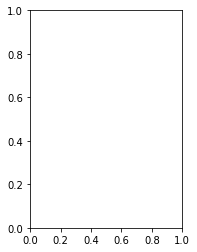

In [228]:
device='cpu'
args.lr = 1
args.epochs = 7
model = models.alexnet(pretrained=False).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)



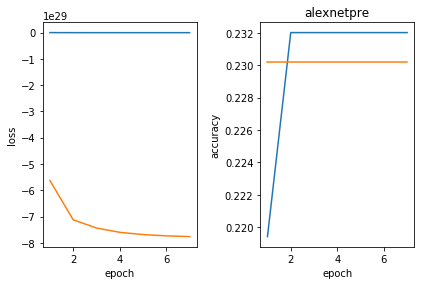

In [229]:
net_name = 'alexnetpre'
torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs+1),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs+1),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs+1),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs+1),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

In [230]:
device='cpu'
args.lr = 1
args.epochs = 7
model = models.squeezenet1_0(pretrained=True).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)

net_name = 'squeezenetpretrained'
torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs+1),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs+1),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs+1),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs+1),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /home/rccheng/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth



Train Epoch: 1 [0/556 (0%)]	Loss: -3.564900, Accuracy: 0/16 (0%)

Train Epoch: 1 [160/556 (29%)]	Loss: -682923973997017027313664.000000, Accuracy: 2/16 (12%)

Train Epoch: 1 [320/556 (58%)]	Loss: -713902686595426853847040.000000, Accuracy: 1/16 (6%)

Train Epoch: 1 [480/556 (86%)]	Loss: -653616060831564635832320.000000, Accuracy: 0/16 (0%)


Test set: Average loss: -114820521625979446930440192.0000, Accuracy: 27/139 (19%)



KeyboardInterrupt: 

In [231]:
device='cpu'
args.lr = 1
args.epochs = 10
model = models.vgg16(pretrained=True).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)

net_name = 'vgg16pretrained'
torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/rccheng/.cache/torch/checkpoints/vgg16-397923af.pth



Train Epoch: 1 [0/556 (0%)]	Loss: -0.628223, Accuracy: 0/16 (0%)



KeyboardInterrupt: 

In [ ]:
device='cpu'
args.lr = 1
args.epochs = 10
net_name = 'densenetpretrained'
model = models.densenet161(pretrained=True).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)


torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /home/rccheng/.cache/torch/checkpoints/densenet161-8d451a50.pth



Train Epoch: 1 [0/556 (0%)]	Loss: 0.197205, Accuracy: 0/16 (0%)

Train Epoch: 1 [160/556 (29%)]	Loss: -38.150936, Accuracy: 11/16 (69%)

Train Epoch: 1 [320/556 (58%)]	Loss: -59.585178, Accuracy: 9/16 (56%)

Train Epoch: 1 [480/556 (86%)]	Loss: -114.476707, Accuracy: 11/16 (69%)


Test set: Average loss: -1263.2636, Accuracy: 58/139 (42%)

Train Epoch: 2 [0/556 (0%)]	Loss: -130.813080, Accuracy: 8/16 (50%)



In [ ]:
device='cpu'
args.lr = 1
args.epochs = 10
net_name = 'inceptionpretrained'
model = models.inception_v3(pretrained=True).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)


torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

In [ ]:
device='cpu'
args.lr = 1
args.epochs = 10
net_name = 'googlenetpretrained'
model = models.googlenet(pretrained=True).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)


torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

In [ ]:
device='cpu'
args.lr = 1
args.epochs = 10
net_name = 'shufflenet_v2_x1_0pretrained'
model = models.shufflenet_v2_x1_0(pretrained=True).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)


torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

In [ ]:
device='cpu'
args.lr = 1
args.epochs = 10
net_name = 'mobilenet_v2pretrained'
model = models.mobilenet_v2(pretrained=True).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)


torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

In [ ]:
device='cpu'
args.lr = 1
args.epochs = 10
net_name = 'mnasnet1_0pretrained'
model = models.mnasnet1_0(pretrained=True).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)


torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

In [ ]:
device='cpu'
args.lr = 1
args.epochs = 10
net_name = 'resnext50_32x4d'
model = models.resnext50_32x4d(pretrained=True).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)


torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

In [ ]:
device='cpu'
args.lr = 1
args.epochs = 10
net_name = 'wide_resnet50_2'
model = models.wide_resnet50_2(pretrained=True).to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)


torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

In [ ]:
device='cpu'
args.lr = 1
args.epoch = 6
model = Net().to(device)
net_name='my_net'
# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
TRAIN_ACCURACY = []; TEST_ACCURACY = [];TRAIN_LOSS = []; TEST_LOSS = []
for epoch in range(1, args.epochs + 1):
    train_accuracy,train_loss = train(args, model, device, TrainLoader, optimizer, epoch)
    test_accuracy,test_loss = test(model, device, ValidateLoader)
    scheduler.step()    # learning rate scheduler
    TRAIN_ACCURACY.append(train_accuracy)
    TEST_ACCURACY.append(test_accuracy)
    TRAIN_LOSS.append(train_loss)
    TEST_LOSS.append(test_loss)
TRAIN_ACCURACY = np.array(TRAIN_ACCURACY)
TRAIN_LOSS = np.array(TRAIN_LOSS)
TEST_ACCURACY = np.array(TEST_ACCURACY)
TEST_LOSS = np.array(TEST_LOSS)
print(TRAIN_ACCURACY)
print(TEST_LOSS)

torch.save(model.state_dict(), net_name+'.pt')
plt.figure()
plt.subplot(1,2,1)
plt.plot( range(1, args.epochs),TRAIN_LOSS,label='train')
plt.plot(range(1, args.epochs),TEST_LOSS,label='validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot( range(1, args.epochs),TRAIN_ACCURACY,label='train')
plt.plot(range(1, args.epochs),TEST_ACCURACY,label='validate')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.tight_layout()
plt.title(net_name)
plt.savefig('../figures/'+net_name+'.png')

In [153]:
transform

array([ 91.35478 , 104.1402  ,  83.619156], dtype=float32)

In [158]:
TrainSet = oversample(filenames = files_train, targets = target_train, directory = '/net/fluo/data2/groupMembers/rccheng/PhenoCam/Datasets/processed/')




In [160]:
TrainSet[0]['image'].shape

(860, 1296, 3)

In [163]:
(TrainSet[0]['image'] - np.array(mean))/np.array(std)

array([[[ 1.6455089 ,  1.533823  ,  1.7047068 ],
        [ 0.25618428,  0.14727063,  0.20971934],
        [ 0.5002548 ,  0.42832854,  0.5329599 ],
        ...,
        [ 0.9320719 ,  1.1965535 ,  2.0481498 ],
        [ 0.80064934,  1.1028675 ,  1.9673396 ],
        [ 0.35005757,  0.6531749 ,  1.4824789 ]],

       [[ 1.1385932 ,  1.0279187 ,  1.1592383 ],
        [ 0.48148015,  0.37211695,  0.45214972],
        [ 0.875748  ,  0.765598  ,  0.91680795],
        ...,
        [-0.10053419,  0.16600783,  0.9370105 ],
        [ 0.18108566,  0.44706574,  1.2400485 ],
        [ 0.18108566,  0.48454013,  1.3006561 ]],

       [[ 1.0071706 ,  0.8967584 ,  1.0178206 ],
        [ 0.83819866,  0.72812366,  0.8359978 ],
        [ 1.1761425 ,  1.0653931 ,  1.2400485 ],
        ...,
        [-0.4009287 , -0.11505008,  0.5733649 ],
        [-0.25073144,  0.01611028,  0.77539027],
        [-0.4009287 , -0.13378727,  0.61377   ]],

       ...,

       [[-1.4898587 , -1.557814  , -0.96202755],
        [-0

In [146]:
for batch_idx, sample_batched in enumerate(TrainLoader,-1):
    sample_batched['image']

TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, *, Number alpha)
 * (Tensor input, Number other, Number alpha)


In [99]:
model.fc1.weight.shape

torch.Size([10, 64])

In [ ]:
model weight
last x
